# Support/Resistance Pattern Detection with Replay Mode

This notebook replicates the sr_patterns.py functionality with an added **replay mode**.

Set `REPLAY_TIME` to a datetime string (e.g., `"2026-01-20 14:00"`) to see what the chart and patterns would have looked like at that historical moment. Future candles are shown in gray.

In [17]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_PATH = "riverusdt_1h.csv"
START_DATE = "2026-01-17"  # Set to None to use all data

# REPLAY MODE: Set to a datetime string to replay historical moment
# Format: "YYYY-MM-DD HH:MM" (24-hour format)
# Set to None for normal mode (use all data as current)
REPLAY_TIME = "2026-01-24"  # e.g., "2026-01-20 14:00"
# =============================================================================

In [18]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from dataclasses import dataclass, field
from typing import Optional
from datetime import datetime
import os
import re

In [19]:
def extract_token_and_interval(filepath: str) -> tuple[str, str]:
    """
    Extract token and interval from filename.
    Examples:
        "riverusdt_1h.csv" -> ("RIVER", "1H")
        "data/btc_4h.csv" -> ("BTC", "4H")
    """
    basename = os.path.basename(filepath)
    name = os.path.splitext(basename)[0]

    match = re.match(r"^(.+?)(?:usdt|usd|usdc|busd)?_(\d+[mhd])$", name, re.IGNORECASE)
    if match:
        token = match.group(1).upper()
        interval = match.group(2).upper()
        return token, interval

    parts = name.split("_")
    if len(parts) >= 2:
        token = parts[0].upper()
        for suffix in ["USDT", "USD", "USDC", "BUSD"]:
            if token.endswith(suffix):
                token = token[:-len(suffix)]
                break
        interval = parts[-1].upper()
        return token, interval

    return name.upper(), ""

In [20]:
@dataclass
class SRParams:
    """Parameters for pattern detection."""
    window_left: int = 1
    window_right: int = 5
    atr_period: int = 14
    atr_multiplier: float = 0.5
    sr_eps_pct: float = 0.01
    lookback: int = 100
    min_touches: int = 2
    zone_merge_factor: float = 1.5
    slope_tolerance: float = 0.0001
    max_lines: int = 10
    consol_window: int = 10
    consol_range_pct: float = 0.15
    consol_slope_threshold: float = 0.008
    consol_min_duration: int = 10


@dataclass
class HorizontalZone:
    """Horizontal support/resistance zone."""
    price_low: float
    price_high: float
    price_center: float
    start_idx: int
    end_idx: int
    touches: int
    zone_type: str
    strength: float


@dataclass
class TrendLine:
    """Tilted support or resistance line."""
    x1: int
    y1: float
    x2: int
    y2: float
    slope: float
    line_type: str
    touches: int
    strength: float


@dataclass
class TrianglePattern:
    """Triangle/wedge pattern."""
    support_line: TrendLine
    resistance_line: TrendLine
    apex_x: int
    apex_price: float
    pattern_type: str
    breakout_bias: str
    completion_pct: float


@dataclass
class ConsolidationZone:
    """Consolidation/accumulation zone."""
    start_idx: int
    end_idx: int
    price_low: float
    price_high: float
    price_center: float
    channel_width_pct: float
    avg_slope: float
    duration: int


@dataclass
class PatternResult:
    """Container for all detected patterns."""
    df: pl.DataFrame
    horizontal_zones: list[HorizontalZone] = field(default_factory=list)
    support_lines: list[TrendLine] = field(default_factory=list)
    resistance_lines: list[TrendLine] = field(default_factory=list)
    triangles: list[TrianglePattern] = field(default_factory=list)
    consolidation_zones: list[ConsolidationZone] = field(default_factory=list)
    current_trend: int = 0
    trend_slope: float = 0.0
    eps: float = 0.0
    sr_eps: float = 0.0
    replay_idx: Optional[int] = None  # Index of replay cutoff (None = no replay)

In [21]:
def calculate_atr(df: pl.DataFrame, period: int = 14) -> pl.DataFrame:
    """Calculate Average True Range."""
    return df.with_columns([
        pl.max_horizontal(
            pl.col("high") - pl.col("low"),
            (pl.col("high") - pl.col("close").shift(1)).abs(),
            (pl.col("low") - pl.col("close").shift(1)).abs()
        ).alias("tr")
    ]).with_columns([
        pl.col("tr").rolling_mean(window_size=period).alias("atr")
    ])


def detect_local_extrema(df: pl.DataFrame, window_left: int, window_right: int) -> pl.DataFrame:
    """
    Detect local highs and lows with asymmetrical window.
    """
    n = len(df)
    highs = df["high"].to_numpy()
    lows = df["low"].to_numpy()

    is_local_high = np.zeros(n, dtype=bool)
    is_local_low = np.zeros(n, dtype=bool)

    for i in range(n):
        left_bound = max(0, i - window_left)
        right_bound = min(n - 1, i + window_right)

        if i < window_left:
            continue

        window_highs = highs[left_bound:right_bound + 1]
        window_lows = lows[left_bound:right_bound + 1]

        if highs[i] >= np.max(window_highs) - 1e-10:
            is_local_high[i] = True
        if lows[i] <= np.min(window_lows) + 1e-10:
            is_local_low[i] = True

    df = df.with_columns([
        pl.Series("is_local_high", is_local_high),
        pl.Series("is_local_low", is_local_low),
    ])

    return df

In [22]:
def find_horizontal_zones(
    local_prices: np.ndarray,
    local_indices: np.ndarray,
    eps: float,
    current_idx: int,
    min_touches: int,
    merge_factor: float,
    zone_type: str
) -> list[HorizontalZone]:
    """Cluster price levels into horizontal zones."""
    if len(local_prices) < min_touches:
        return []

    sorted_idx = np.argsort(local_prices)
    sorted_prices = local_prices[sorted_idx]
    sorted_bar_indices = local_indices[sorted_idx]

    zones = []
    merge_dist = eps * merge_factor

    i = 0
    while i < len(sorted_prices):
        cluster_prices = [sorted_prices[i]]
        cluster_indices = [sorted_bar_indices[i]]

        j = i + 1
        while j < len(sorted_prices) and sorted_prices[j] - sorted_prices[i] <= merge_dist:
            cluster_prices.append(sorted_prices[j])
            cluster_indices.append(sorted_bar_indices[j])
            j += 1

        if len(cluster_prices) >= min_touches:
            price_low = min(cluster_prices)
            price_high = max(cluster_prices)
            price_center = np.mean(cluster_prices)

            recency_weight = np.mean([(idx / current_idx) for idx in cluster_indices])
            strength = len(cluster_prices) * (0.5 + 0.5 * recency_weight)

            zones.append(HorizontalZone(
                price_low=price_center - eps * 0.5,
                price_high=price_center + eps * 0.5,
                price_center=price_center,
                start_idx=int(min(cluster_indices)),
                end_idx=int(max(cluster_indices)),
                touches=len(cluster_prices),
                zone_type=zone_type,
                strength=strength
            ))

        i = j

    return zones

In [23]:
def is_valid_line(
    prices: np.ndarray,
    x1: int, y1: float,
    slope: float,
    current_idx: int,
    eps: float,
    line_type: str
) -> tuple[bool, int]:
    """
    Check if line is valid and count touches.
    """
    touches = 0
    break_tolerance = eps * 0.1

    for offset in range(current_idx - x1 + 1):
        bar_idx = x1 + offset
        if bar_idx >= len(prices):
            break

        line_y = y1 + slope * offset
        price = prices[bar_idx]

        if line_type == 'support':
            if price < line_y - break_tolerance:
                return False, 0
            if price >= line_y - break_tolerance and price <= line_y + eps:
                touches += 1
        else:
            if price > line_y + break_tolerance:
                return False, 0
            if price <= line_y + break_tolerance and price >= line_y - eps:
                touches += 1

    return True, touches


def find_trendlines(
    local_prices: np.ndarray,
    local_indices: np.ndarray,
    all_prices: np.ndarray,
    eps: float,
    current_idx: int,
    current_price: float,
    line_type: str,
    max_lines: int,
    slope_tolerance: float,
    required_slope_sign: Optional[int] = None
) -> list[TrendLine]:
    """
    Find valid trend lines with slope constraints.
    """
    if len(local_prices) < 2:
        return []

    lines = []

    for i in range(len(local_prices)):
        for j in range(i + 1, len(local_prices)):
            x1, y1 = int(local_indices[i]), local_prices[i]
            x2, y2 = int(local_indices[j]), local_prices[j]

            if x1 >= x2:
                continue

            slope = (y2 - y1) / (x2 - x1)

            if required_slope_sign is not None:
                if required_slope_sign == 1 and slope <= 0:
                    continue
                if required_slope_sign == -1 and slope >= 0:
                    continue

            valid, touches = is_valid_line(
                all_prices, x1, y1, slope, current_idx, eps, line_type
            )

            if valid and touches >= 2:
                end_x = current_idx + 30
                end_y = y1 + slope * (end_x - x1)
                line_at_current = y1 + slope * (current_idx - x1)

                span = x2 - x1
                span_score = span / current_idx
                recency = x2 / current_idx

                distance_pct = abs(line_at_current - current_price) / current_price
                proximity = 1.0 / (1.0 + distance_pct * 10)

                strength = touches * (0.2 * span_score + 0.2 * recency + 0.6 * proximity)

                lines.append(TrendLine(
                    x1=x1, y1=y1,
                    x2=end_x, y2=end_y,
                    slope=slope,
                    line_type=line_type,
                    touches=touches,
                    strength=strength
                ))

    lines.sort(key=lambda x: x.strength, reverse=True)
    return lines[:max_lines]

In [24]:
def find_triangles(
    support_lines: list[TrendLine],
    resistance_lines: list[TrendLine],
    current_idx: int,
    current_price: float,
    eps: float,
    slope_tolerance: float
) -> list[TrianglePattern]:
    """Detect triangle patterns from converging lines."""
    triangles = []

    for sup in support_lines:
        for res in resistance_lines:
            if sup.x1 > res.x2 or res.x1 > sup.x2:
                continue

            slope_diff = res.slope - sup.slope

            if abs(slope_diff) < 1e-10:
                continue

            x_intersect = (res.y1 - sup.y1 + sup.slope * sup.x1 - res.slope * res.x1) / slope_diff
            y_intersect = sup.y1 + sup.slope * (x_intersect - sup.x1)

            if x_intersect <= current_idx or x_intersect > current_idx + 100:
                continue

            sup_at_current = sup.y1 + sup.slope * (current_idx - sup.x1)
            res_at_current = res.y1 + res.slope * (current_idx - res.x1)

            if sup_at_current >= res_at_current:
                continue

            sup_is_flat = abs(sup.slope) < slope_tolerance
            res_is_flat = abs(res.slope) < slope_tolerance
            sup_rising = sup.slope > slope_tolerance
            sup_falling = sup.slope < -slope_tolerance
            res_rising = res.slope > slope_tolerance
            res_falling = res.slope < -slope_tolerance

            if sup_rising and res_is_flat:
                pattern_type = "ascending"
                bias = "bullish"
            elif sup_is_flat and res_falling:
                pattern_type = "descending"
                bias = "bearish"
            elif sup_rising and res_falling:
                pattern_type = "symmetrical"
                bias = "neutral"
            elif sup_rising and res_rising and res.slope > sup.slope:
                pattern_type = "rising_wedge"
                bias = "bearish"
            elif sup_falling and res_falling and sup.slope < res.slope:
                pattern_type = "falling_wedge"
                bias = "bullish"
            else:
                continue

            pattern_start = max(sup.x1, res.x1)
            total_span = x_intersect - pattern_start
            current_progress = current_idx - pattern_start
            completion = min(100, max(0, (current_progress / total_span) * 100))

            triangles.append(TrianglePattern(
                support_line=sup,
                resistance_line=res,
                apex_x=int(x_intersect),
                apex_price=y_intersect,
                pattern_type=pattern_type,
                breakout_bias=bias,
                completion_pct=completion
            ))

    triangles.sort(key=lambda x: x.completion_pct, reverse=True)
    return triangles[:5]

In [25]:
def detect_consolidation_zones(
    df: pl.DataFrame,
    window: int,
    range_pct_threshold: float,
    slope_threshold: float,
    min_duration: int
) -> list[ConsolidationZone]:
    """
    Detect consolidation zones based on channel tightness and trend flatness.
    """
    n = len(df)
    if n < window:
        return []

    highs = df["high"].to_numpy()
    lows = df["low"].to_numpy()
    closes = df["close"].to_numpy()

    rolling_max = np.empty(n)
    rolling_min = np.empty(n)
    rolling_max[:] = np.nan
    rolling_min[:] = np.nan

    for i in range(window - 1, n):
        rolling_max[i] = np.max(highs[i - window + 1:i + 1])
        rolling_min[i] = np.min(lows[i - window + 1:i + 1])

    channel_width_pct = (rolling_max - rolling_min) / rolling_min

    slopes = np.empty(n)
    slopes[:] = np.nan
    x = np.arange(window)

    for i in range(window - 1, n):
        y = closes[i - window + 1:i + 1]
        y_norm = y / y[0] if y[0] != 0 else y
        slope, _ = np.polyfit(x, y_norm, 1)
        slopes[i] = slope

    is_consolidation = (
        (channel_width_pct <= range_pct_threshold) &
        (np.abs(slopes) <= slope_threshold) &
        ~np.isnan(channel_width_pct)
    )

    zones = []
    i = 0
    while i < n:
        if is_consolidation[i]:
            start_idx = i
            while i < n and is_consolidation[i]:
                i += 1
            end_idx = i - 1
            duration = end_idx - start_idx + 1

            if duration >= min_duration:
                zone_high = np.max(highs[start_idx:end_idx + 1])
                zone_low = np.min(lows[start_idx:end_idx + 1])

                extended_start = start_idx
                for j in range(start_idx - 1, -1, -1):
                    bar_in_range = (lows[j] <= zone_high and highs[j] >= zone_low)
                    if bar_in_range:
                        extended_start = j
                    else:
                        break

                zone_high = np.max(highs[extended_start:end_idx + 1])
                zone_low = np.min(lows[extended_start:end_idx + 1])
                zone_center = (zone_high + zone_low) / 2
                width_pct = (zone_high - zone_low) / zone_low if zone_low > 0 else 0
                duration = end_idx - extended_start + 1

                valid_slopes = slopes[start_idx:end_idx + 1]
                valid_slopes = valid_slopes[~np.isnan(valid_slopes)]
                avg_slope = np.mean(valid_slopes) if len(valid_slopes) > 0 else 0

                zones.append(ConsolidationZone(
                    start_idx=extended_start,
                    end_idx=end_idx,
                    price_low=zone_low,
                    price_high=zone_high,
                    price_center=zone_center,
                    channel_width_pct=width_pct,
                    avg_slope=avg_slope,
                    duration=duration
                ))
        else:
            i += 1

    return zones

In [26]:
def detect_patterns(
    df: pl.DataFrame, 
    params: SRParams = None,
    replay_idx: Optional[int] = None
) -> PatternResult:
    """
    Main function to detect all patterns.
    
    If replay_idx is provided, patterns are detected as if that bar is the "current" bar.
    The full dataframe is returned for plotting, but pattern detection only uses data up to replay_idx.
    """
    if params is None:
        params = SRParams()

    # Add bar index to full dataframe
    df = df.with_row_index("bar_index")
    
    # For pattern detection, use only data up to replay_idx (or all data if None)
    if replay_idx is not None:
        df_analysis = df.filter(pl.col("bar_index") <= replay_idx)
    else:
        df_analysis = df
    
    # Calculate ATR-based eps
    df_analysis = calculate_atr(df_analysis, params.atr_period)
    current_eps = df_analysis["atr"][-1] * params.atr_multiplier
    if np.isnan(current_eps):
        current_eps = df_analysis["atr"].drop_nulls()[-1] * params.atr_multiplier

    # Calculate percentage-based eps for S/R zones
    current_price = df_analysis["close"][-1]
    sr_eps = current_price * params.sr_eps_pct

    # Detect local extrema
    df_analysis = detect_local_extrema(df_analysis, params.window_left, params.window_right)

    # Calculate trend
    df_analysis = df_analysis.with_columns([
        pl.col("close").ewm_mean(span=50, adjust=False).alias("ema_50")
    ])
    ema_now = df_analysis["ema_50"][-1]
    ema_prev = df_analysis["ema_50"][-50] if len(df_analysis) > 50 else df_analysis["ema_50"][0]
    trend_slope = ((ema_now - ema_prev) / ema_prev * 100) if ema_prev else 0
    current_trend = 1 if trend_slope > 0.5 else (-1 if trend_slope < -0.5 else 0)

    # Get arrays
    current_idx = len(df_analysis) - 1
    min_bar = max(0, current_idx - params.lookback)

    highs = df_analysis["high"].to_numpy()
    lows = df_analysis["low"].to_numpy()

    # Detect consolidation zones
    consolidation_zones = detect_consolidation_zones(
        df_analysis,
        window=params.consol_window,
        range_pct_threshold=params.consol_range_pct,
        slope_threshold=params.consol_slope_threshold,
        min_duration=params.consol_min_duration
    )

    # Get local highs/lows within lookback
    local_highs_df = df_analysis.filter(
        (pl.col("is_local_high")) & (pl.col("bar_index") >= min_bar)
    )
    local_lows_df = df_analysis.filter(
        (pl.col("is_local_low")) & (pl.col("bar_index") >= min_bar)
    )

    local_high_prices = local_highs_df["high"].to_numpy()
    local_high_indices = local_highs_df["bar_index"].to_numpy()
    local_low_prices = local_lows_df["low"].to_numpy()
    local_low_indices = local_lows_df["bar_index"].to_numpy()

    # Filter extrema in consolidation zones
    def filter_extrema_for_consolidation(prices, indices, is_high=True):
        filtered_prices = []
        filtered_indices = []
        used_in_consol = set()

        consol_extrema = {}
        for i, (price, idx) in enumerate(zip(prices, indices)):
            for z_idx, cz in enumerate(consolidation_zones):
                if cz.start_idx <= idx <= cz.end_idx:
                    used_in_consol.add(i)
                    if z_idx not in consol_extrema:
                        consol_extrema[z_idx] = []
                    consol_extrema[z_idx].append((price, idx))
                    break

        for i, (price, idx) in enumerate(zip(prices, indices)):
            if i not in used_in_consol:
                filtered_prices.append(price)
                filtered_indices.append(idx)

        for z_idx, extrema_list in consol_extrema.items():
            if not extrema_list:
                continue

            sorted_extrema = sorted(extrema_list, key=lambda x: x[0])
            clusters = []
            current_cluster = [sorted_extrema[0]]

            for price, idx in sorted_extrema[1:]:
                if price - current_cluster[0][0] <= sr_eps:
                    current_cluster.append((price, idx))
                else:
                    clusters.append(current_cluster)
                    current_cluster = [(price, idx)]
            clusters.append(current_cluster)

            for cluster in clusters:
                if is_high:
                    best = max(cluster, key=lambda x: x[0])
                else:
                    best = min(cluster, key=lambda x: x[0])
                filtered_prices.append(best[0])
                filtered_indices.append(best[1])

        return np.array(filtered_prices), np.array(filtered_indices)

    sr_high_prices, sr_high_indices = filter_extrema_for_consolidation(
        local_high_prices, local_high_indices, is_high=True
    )
    sr_low_prices, sr_low_indices = filter_extrema_for_consolidation(
        local_low_prices, local_low_indices, is_high=False
    )

    # Find horizontal zones
    support_zones = find_horizontal_zones(
        sr_low_prices, sr_low_indices, sr_eps, current_idx,
        params.min_touches, params.zone_merge_factor, "support"
    )
    resistance_zones = find_horizontal_zones(
        sr_high_prices, sr_high_indices, sr_eps, current_idx,
        params.min_touches, params.zone_merge_factor, "resistance"
    )

    # Find trend lines with slope constraints
    if current_trend == 1:
        support_slope_sign = 1
        resistance_slope_sign = -1
        support_max = params.max_lines
        resistance_max = max(3, params.max_lines // 3)
    elif current_trend == -1:
        support_slope_sign = 1
        resistance_slope_sign = -1
        support_max = max(3, params.max_lines // 3)
        resistance_max = params.max_lines
    else:
        support_slope_sign = None
        resistance_slope_sign = None
        support_max = params.max_lines
        resistance_max = params.max_lines

    support_lines = find_trendlines(
        local_low_prices, local_low_indices, lows, current_eps,
        current_idx, current_price, "support", support_max, params.slope_tolerance,
        required_slope_sign=support_slope_sign
    )
    resistance_lines = find_trendlines(
        local_high_prices, local_high_indices, highs, current_eps,
        current_idx, current_price, "resistance", resistance_max, params.slope_tolerance,
        required_slope_sign=resistance_slope_sign
    )

    # Find triangles
    triangles = find_triangles(
        support_lines, resistance_lines, current_idx,
        df_analysis["close"][-1], current_eps, params.slope_tolerance
    )

    # Add local extrema columns to full dataframe for plotting
    # (we need to recalculate for the full df since df_analysis is a subset)
    df_full = calculate_atr(df, params.atr_period)
    df_full = detect_local_extrema(df_full, params.window_left, params.window_right)

    return PatternResult(
        df=df_full,
        horizontal_zones=support_zones + resistance_zones,
        support_lines=support_lines,
        resistance_lines=resistance_lines,
        triangles=triangles,
        consolidation_zones=consolidation_zones,
        current_trend=current_trend,
        trend_slope=trend_slope,
        eps=current_eps,
        sr_eps=sr_eps,
        replay_idx=replay_idx
    )

In [27]:
def plot_patterns(result: PatternResult, title: str = "Support & Resistance Patterns"):
    """
    Plot all detected patterns.
    
    If result.replay_idx is set, candles after that index are shown in gray:
    - Hollow (outline only) for bullish candles (close >= open)
    - Filled for bearish candles (close < open)
    """
    df = result.df
    replay_idx = result.replay_idx

    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot candlesticks
    times = df["open_time"].to_numpy()
    opens = df["open"].to_numpy()
    highs = df["high"].to_numpy()
    lows = df["low"].to_numpy()
    closes = df["close"].to_numpy()

    width = 0.02
    for i in range(len(df)):
        is_future = replay_idx is not None and i > replay_idx
        is_bullish = closes[i] >= opens[i]
        
        if is_future:
            # Future candles: light gray color, hollow for bullish, filled for bearish
            wick_color = "#B0B0B0"  # Light gray
            if is_bullish:
                # Hollow candle: just outline
                face_color = "none"
                edge_color = "#B0B0B0"
            else:
                # Filled candle
                face_color = "#B0B0B0"
                edge_color = "#B0B0B0"
        else:
            # Normal candles: green for bullish, red for bearish
            if is_bullish:
                wick_color = "#26a69a"
                face_color = "#26a69a"
                edge_color = "#26a69a"
            else:
                wick_color = "#ef5350"
                face_color = "#ef5350"
                edge_color = "#ef5350"
        
        # Draw wick
        ax.plot([times[i], times[i]], [lows[i], highs[i]], color=wick_color, linewidth=0.8)
        
        # Draw body
        body_bottom = min(opens[i], closes[i])
        body_height = abs(closes[i] - opens[i])
        rect = Rectangle(
            (mdates.date2num(times[i]) - width / 2, body_bottom),
            width, body_height,
            facecolor=face_color, edgecolor=edge_color, linewidth=1.2
        )
        ax.add_patch(rect)

    # Determine the cutoff index for plotting markers/patterns
    # Only show local highs/lows up to replay_idx
    if replay_idx is not None:
        df_visible = df.filter(pl.col("bar_index") <= replay_idx)
    else:
        df_visible = df
    
    # Plot local highs/lows (only up to replay time)
    local_highs = df_visible.filter(pl.col("is_local_high"))
    local_lows = df_visible.filter(pl.col("is_local_low"))

    if local_highs.height > 0:
        ax.scatter(local_highs["open_time"].to_numpy(), local_highs["high"].to_numpy(),
                   marker="v", color="red", s=30, alpha=0.7, zorder=5, label=f"Local Highs ({local_highs.height})")
    if local_lows.height > 0:
        ax.scatter(local_lows["open_time"].to_numpy(), local_lows["low"].to_numpy(),
                   marker="^", color="lime", s=30, alpha=0.7, zorder=5, label=f"Local Lows ({local_lows.height})")

    # Plot horizontal zones as lines (light yellow) with price labels
    for zone in result.horizontal_zones:
        alpha = min(0.9, 0.5 + zone.strength * 0.1)
        linewidth = min(2.5, 1 + zone.touches * 0.3)

        x_start = times[zone.start_idx]
        # Extend to replay time or end of data
        if replay_idx is not None:
            x_end = times[min(replay_idx, len(times) - 1)]
        else:
            x_end = times[-1]

        ax.hlines(y=zone.price_center, xmin=x_start, xmax=x_end,
                  color="#FFEB3B", linewidth=linewidth, alpha=alpha, linestyle="-")

        ax.text(x_end, zone.price_center, f" {zone.price_center:.4f} ",
                fontsize=7, color="black", va="center", ha="left",
                bbox=dict(boxstyle="round,pad=0.15", facecolor="#FFEB3B", edgecolor="none", alpha=0.9))

    # Helper to convert bar index to time
    def idx_to_time(idx):
        if idx < len(times):
            return times[idx]
        else:
            time_delta = times[-1] - times[-2]
            return times[-1] + time_delta * (idx - len(times) + 1)

    # For trendlines in replay mode, limit x2 to not extend past replay_idx too much
    def get_line_end_idx(line):
        if replay_idx is not None:
            return min(line.x2, replay_idx + 30)
        return line.x2

    # Plot support lines (green)
    for i, line in enumerate(result.support_lines[:10]):
        style = "-" if line.slope >= 0 else "--"
        alpha = min(0.7, 0.3 + line.strength * 0.1)
        end_idx = get_line_end_idx(line)
        end_y = line.y1 + line.slope * (end_idx - line.x1)
        ax.plot([idx_to_time(line.x1), idx_to_time(end_idx)], [line.y1, end_y],
                color="green", linewidth=1, linestyle=style, alpha=alpha)

    # Plot resistance lines (red)
    for i, line in enumerate(result.resistance_lines[:10]):
        style = "-" if line.slope <= 0 else "--"
        alpha = min(0.7, 0.3 + line.strength * 0.1)
        end_idx = get_line_end_idx(line)
        end_y = line.y1 + line.slope * (end_idx - line.x1)
        ax.plot([idx_to_time(line.x1), idx_to_time(end_idx)], [line.y1, end_y],
                color="red", linewidth=1, linestyle=style, alpha=alpha)

    # Highlight triangles
    for tri in result.triangles:
        sup, res = tri.support_line, tri.resistance_line
        
        # Limit apex display in replay mode
        apex_x_display = tri.apex_x
        if replay_idx is not None:
            apex_x_display = min(apex_x_display, replay_idx + 50)
        apex_y_display = sup.y1 + sup.slope * (apex_x_display - sup.x1)

        ax.plot([idx_to_time(sup.x1), idx_to_time(apex_x_display)],
                [sup.y1, apex_y_display],
                color="blue", linewidth=2, alpha=0.8)
        
        apex_y_res = res.y1 + res.slope * (apex_x_display - res.x1)
        ax.plot([idx_to_time(res.x1), idx_to_time(apex_x_display)],
                [res.y1, apex_y_res],
                color="blue", linewidth=2, alpha=0.8)

        ax.scatter([idx_to_time(tri.apex_x)], [tri.apex_price],
                   marker="*", color="yellow", s=200, zorder=10, edgecolor="black")

        bias_color = "green" if tri.breakout_bias == "bullish" else ("red" if tri.breakout_bias == "bearish" else "gray")
        ax.annotate(f"{tri.pattern_type}\n{tri.completion_pct:.0f}% complete\n{tri.breakout_bias}",
                    xy=(idx_to_time(tri.apex_x), tri.apex_price),
                    xytext=(10, 10), textcoords="offset points",
                    fontsize=9, color=bias_color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Plot consolidation zones (orange rectangles) - only up to replay_idx
    for cz in result.consolidation_zones:
        # Skip zones that are entirely after replay time
        if replay_idx is not None and cz.start_idx > replay_idx:
            continue
            
        x_start = times[cz.start_idx]
        end_idx = cz.end_idx
        if replay_idx is not None:
            end_idx = min(end_idx, replay_idx)
        x_end = times[min(end_idx, len(times) - 1)]

        rect = Rectangle(
            (mdates.date2num(x_start), cz.price_low),
            mdates.date2num(x_end) - mdates.date2num(x_start),
            cz.price_high - cz.price_low,
            facecolor="orange", alpha=0.25, edgecolor="orange",
            linewidth=1.5, linestyle="--", zorder=2
        )
        ax.add_patch(rect)

        if cz.duration >= 15:
            mid_idx = (cz.start_idx + min(cz.end_idx, end_idx)) // 2
            mid_time = times[mid_idx]
            ax.annotate(f"Consol\n{cz.duration} bars\n{cz.channel_width_pct*100:.1f}%",
                        xy=(mid_time, cz.price_high),
                        xytext=(0, 5), textcoords="offset points",
                        fontsize=8, color="darkorange", ha="center",
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))

    # Add replay time indicator line
    if replay_idx is not None:
        replay_time = times[replay_idx]
        replay_time_str = str(replay_time)[:16]  # Convert numpy datetime64 to string
        ax.axvline(x=replay_time, color="red", linewidth=2, linestyle="--", alpha=0.8, zorder=15)
        ax.text(replay_time, ax.get_ylim()[1], f" REPLAY: {replay_time_str} ",
                fontsize=10, color="white", va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", edgecolor="none", alpha=0.9))

    # Trend indicator box
    if result.current_trend == 1:
        trend_color, trend_text = "green", f"UP\n{result.trend_slope:+.2f}%"
    elif result.current_trend == -1:
        trend_color, trend_text = "red", f"DOWN\n{result.trend_slope:+.2f}%"
    else:
        trend_color, trend_text = "gray", f"SIDE\n{result.trend_slope:+.2f}%"

    ax.text(0.98, 0.98, trend_text, transform=ax.transAxes,
            fontsize=12, fontweight="bold", color="white",
            verticalalignment="top", horizontalalignment="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor=trend_color, alpha=0.8))

    # Stats box
    stats_text = (f"S/R Zones: {len(result.horizontal_zones)}\n"
                  f"Support: {len(result.support_lines)}\n"
                  f"Resistance: {len(result.resistance_lines)}\n"
                  f"Triangles: {len(result.triangles)}\n"
                  f"Consolidation: {len(result.consolidation_zones)}")
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Format
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
    plt.xticks(rotation=45)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

    return fig, ax

In [28]:
def parse_replay_time(time_str: str) -> datetime:
    """
    Parse replay time string. Supports multiple formats:
    - "YYYY-MM-DD HH:MM"
    - "YYYY-MM-DD HH-MM"
    - "YYYY-MM-DD"
    """
    formats = [
        "%Y-%m-%d %H:%M",
        "%Y-%m-%d %H-%M",
        "%Y-%m-%d %H:%M:%S",
        "%Y-%m-%d",
    ]
    for fmt in formats:
        try:
            return datetime.strptime(time_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Could not parse time: {time_str}. Use format like 'YYYY-MM-DD HH:MM'")

In [29]:
# Load and prepare data
token, interval = extract_token_and_interval(DATA_PATH)
print(f"Loading data from: {DATA_PATH}")

df = pl.read_csv(DATA_PATH)
df = df.with_columns([
    pl.col("open_time").str.to_datetime("%Y-%m-%d %H:%M:%S")
])

# Filter by start date if specified
if START_DATE:
    start_date = datetime.strptime(START_DATE, "%Y-%m-%d")
    df = df.filter(pl.col("open_time") >= start_date)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['open_time'].min()} to {df['open_time'].max()}")

Loading data from: riverusdt_1h.csv
Data shape: (186, 12)
Date range: 2026-01-17 00:00:00 to 2026-01-24 17:00:00


In [30]:
# Determine replay index if REPLAY_TIME is set
replay_idx = None

if REPLAY_TIME is not None:
    replay_dt = parse_replay_time(REPLAY_TIME)
    print(f"Replay mode enabled: {replay_dt}")
    
    # Find the bar index closest to (but not after) the replay time
    df_temp = df.with_row_index("_idx")
    matching = df_temp.filter(pl.col("open_time") <= replay_dt)
    
    if matching.height == 0:
        print(f"Warning: No data before {replay_dt}. Using first bar.")
        replay_idx = 0
    else:
        replay_idx = int(matching["_idx"][-1])
        replay_time_str = str(df['open_time'][replay_idx])[:16]
        print(f"Replay bar index: {replay_idx} (time: {replay_time_str})")
        print(f"Future bars shown in gray: {len(df) - replay_idx - 1}")
else:
    print("Normal mode (no replay)")

Replay mode enabled: 2026-01-24 00:00:00
Replay bar index: 168 (time: 2026-01-24 00:00)
Future bars shown in gray: 17


In [31]:
# Detect patterns
params = SRParams(
    window_left=1,
    window_right=5,
    atr_period=14,
    atr_multiplier=0.5,
    lookback=100,
    min_touches=2,
    zone_merge_factor=1.5,
    slope_tolerance=0.0001,
    max_lines=15
)

result = detect_patterns(df, params, replay_idx=replay_idx)

print(f"\nDetected patterns (as of {'replay time' if replay_idx else 'current'}):")
print(f"  Horizontal zones: {len(result.horizontal_zones)}")
print(f"  Support lines: {len(result.support_lines)}")
print(f"  Resistance lines: {len(result.resistance_lines)}")
print(f"  Triangles: {len(result.triangles)}")
print(f"  Consolidation zones: {len(result.consolidation_zones)}")
print(f"  Current eps: {result.eps:.6f}")


Detected patterns (as of replay time):
  Horizontal zones: 6
  Support lines: 3
  Resistance lines: 5
  Triangles: 0
  Consolidation zones: 0
  Current eps: 1.956536


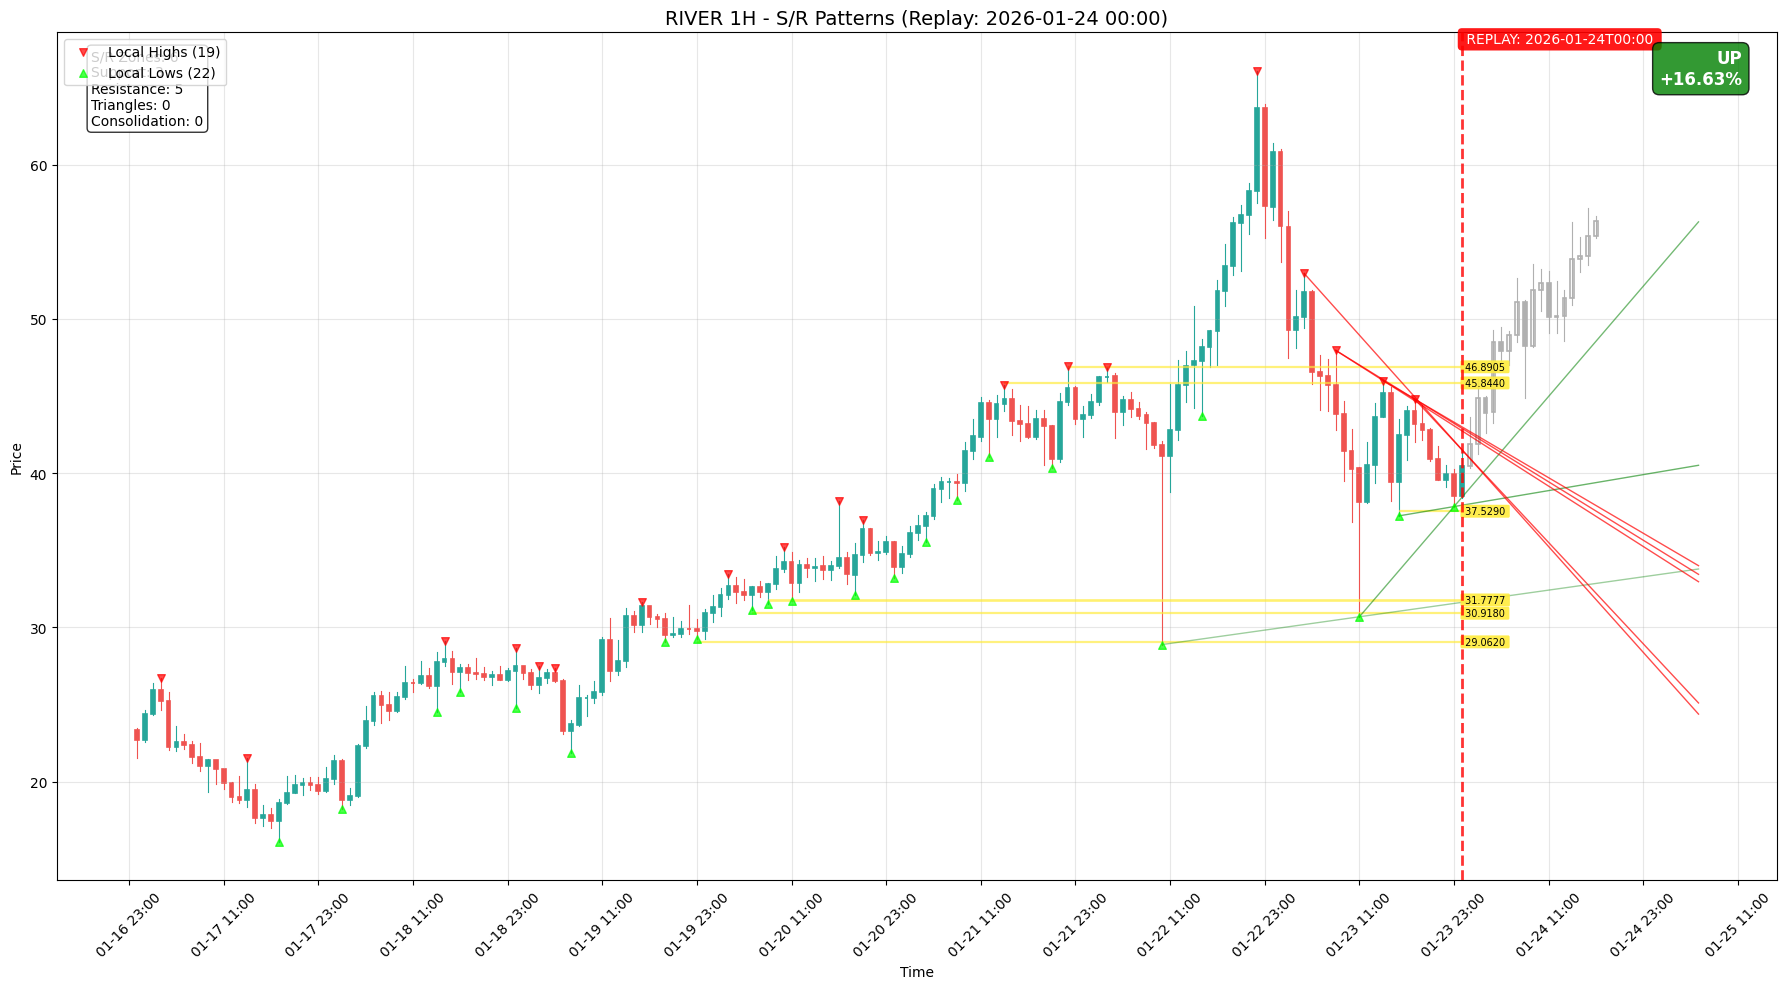

(<Figure size 1800x1000 with 1 Axes>,
 <Axes: title={'center': 'RIVER 1H - S/R Patterns (Replay: 2026-01-24 00:00)'}, xlabel='Time', ylabel='Price'>)

In [32]:
# Plot with dynamic title
if replay_idx is not None:
    replay_time_str = str(df['open_time'][replay_idx])[:16]
    title = f"{token} {interval} - S/R Patterns (Replay: {replay_time_str})"
else:
    title = f"{token} {interval} - Support/Resistance & Patterns"

plot_patterns(result, title)

In [33]:
# Print detected triangles
for tri in result.triangles:
    print(f"\n  Triangle: {tri.pattern_type}")
    print(f"    Bias: {tri.breakout_bias}")
    print(f"    Completion: {tri.completion_pct:.1f}%")
    print(f"    Apex at bar {tri.apex_x}, price {tri.apex_price:.4f}")

In [34]:
# Print consolidation zones
for cz in result.consolidation_zones:
    print(f"\n  Consolidation: bars {cz.start_idx}-{cz.end_idx} ({cz.duration} bars)")
    print(f"    Range: {cz.price_low:.4f} - {cz.price_high:.4f} ({cz.channel_width_pct*100:.2f}%)")
    print(f"    Avg slope: {cz.avg_slope:.6f}")